In [310]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as geo
import matplotlib.colors as colors
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt

In [320]:
# Load data (COVID from https://github.com/charlie-becker/COVID/blob/master/COVID_US.ipynb
    # and shape files from data.gov)
states = geo.read_file('/Users/charlesbecker/Downloads/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
counties = geo.read_file('/Users/charlesbecker/Downloads/tl_2017_us_county/tl_2017_us_county.shp')
states, counties = states.to_crs("EPSG:3395"), counties.to_crs("EPSG:3395")
covid = geo.read_file('/Users/charlesbecker/Desktop/COVID19/data/03-29-2020.csv')

In [321]:
# Change data types, some renaming, and removing non-CONUS space 
convert_dict = {'Confirmed':int, 'Deaths':int, 'Recovered':int, 'Active':int, 'Lat':float, 'Long_':float}
covid = covid.astype(convert_dict)
exclude = ['AK','HI','VI','GU','PR','AS','MP']
exclude_codes = [states.loc[states['STUSPS'] == x, 'STATEFP'].iloc[0] for x in exclude]
CONUS_states = states[~states.STUSPS.isin(exclude)]
CONUS_counties = counties[~counties.STATEFP.isin(exclude_codes)]
covid = covid.rename(columns={'Admin2':'County','Province_State':'State','Country_Region':'Country'})
CONUS_states = CONUS_states.rename(columns={'NAME':'State'})
CONUS_counties = CONUS_counties.rename(columns={'GEOID':'FIPS','NAME':'County'})

In [322]:
# Aggregate state level data and merge with shape file at the state level
state_level = covid.groupby('State').sum().merge(CONUS_states, on=['State'], how='left')
state_level = geo.GeoDataFrame(state_level, crs="EPSG:3395", geometry='geometry')
state_level = state_level[state_level['geometry'] != None]

In [323]:
# Merge county level data with shape file
county_level = covid.drop('geometry', axis=1).merge(CONUS_counties, on=['County','FIPS'], how='left')
county_level = county_level.rename(columns={'Province_State':'State','Country_Region':'Country'})
county_level[['Confirmed','Deaths','Recovered']] = county_level[['Confirmed','Deaths','Recovered']].astype('int32')
county_level = county_level[county_level['Country'] == 'US']

In [324]:
# Function to plot shape and data layers
def make_plot(mapp, level, metric):
    df_sub = level[level[metric] > 0] # only include data with > 0 
    vmin, vmax = 1, np.quantile(df_sub[metric],.98) # only use top 98% data to distribute scale better 
    fig, ax = plt.subplots(figsize=(18,9))
    ax.axis('off')
    mapp.plot(color='lightgrey',edgecolor='k',lw=0.3,ax=ax) # base map
    df_sub.plot(column=metric, legend=True, ax=ax, vmax=vmax) # data
    ax.set_title(str(metric), fontsize= 26)

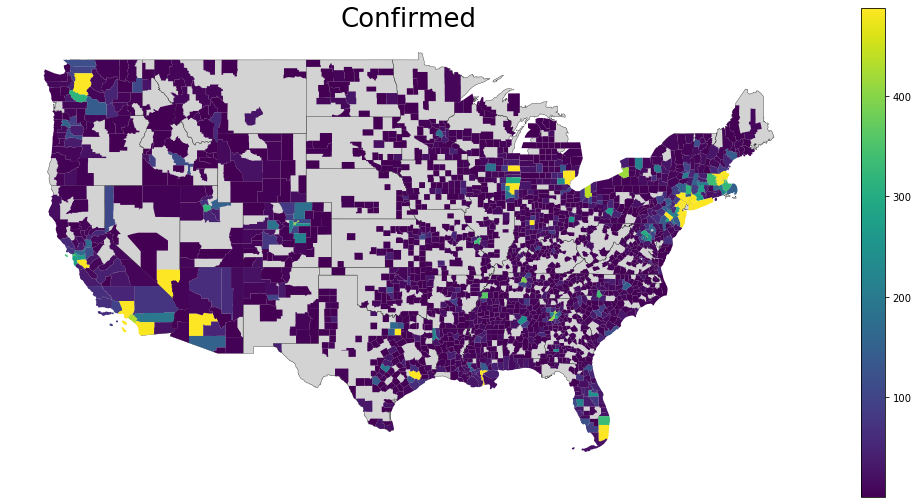

In [325]:
make_plot(mapp=CONUS_states, level=county_level, metric='Confirmed')

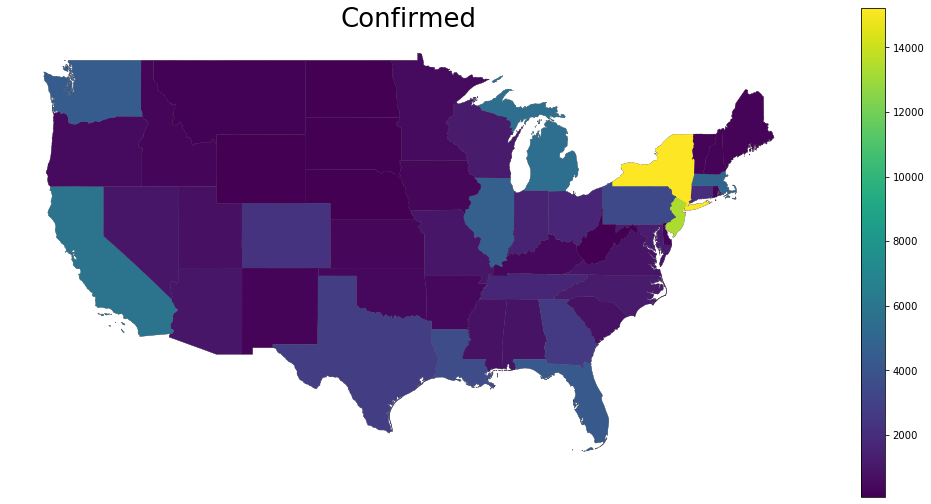

In [326]:
make_plot(CONUS_states, state_level, 'Confirmed')